In [1]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader as GDataLoader, Batch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv, global_max_pool, GCNConv
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT, \
MatchingAttention, getDataLoaderAndLabels,GCNWithSkipConnections, GCNWithConcatenation
from model import DATASET_PATH
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
from sklearn.metrics import classification_report
from model import FCClassifier, MyNetwork, DATASET_PATH, MatchingAttention, RGCNWithGAT, \
RGATWithSkipConnections, EdgeGATWithGCN, EGATConv, EdgeGATWithSkipConnection,Edge2GATWithGCN
EdgeGATWithSkipConnection, EGATConv, EdgeGATWithGCN, \
GCNWithConcatenation
%load_ext autoreload
%autoreload 2

In [2]:
key=False
WINDOW_SIZE = 3

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [3]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

In [4]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [5]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [6]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= WINDOW_SIZE) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [7]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [8]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [9]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [10]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [11]:
file_path1 = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [12]:
# print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

In [13]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

In [14]:
len(edgeIndicesDev[0][0])

3

#### Train without relational features

In [15]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_dev = pickle.load(file)
y_dev = torch.tensor(y_dev)

In [16]:
y_tensor_train = [y_train[start:end + 1] for start, end in rangesTrain]
y_tensor_dev = [y_dev[start:end + 1] for start, end in rangesDev]
y_tensor_test = [y_test[start:end + 1] for start, end in rangesTest]

In [26]:
def getDataset(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
    dataset=[]
    for X, edges, Y, edgeTypes in zip(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
        graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long),
            y=torch.tensor(Y, dtype=torch.long),
            edge_type = torch.tensor(edgeTypes, dtype=torch.long)
        )
        dataset.append(graph_data)
    return dataset

train_dataset = getDataset(contextualEmbeddingsTrain, edgeIndicesTrain, y_tensor_train, edgeTypesTrain)
dev_dataset = getDataset(contextualEmbeddingsDev, edgeIndicesDev, y_tensor_dev, edgeTypesDev)
test_dataset = getDataset(contextualEmbeddingsTest, edgeIndicesTest, y_tensor_test, edgeTypesTest)

train_loader = GDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = GDataLoader(dev_dataset, batch_size=1, shuffle=True)
test_loader = GDataLoader(test_dataset, batch_size=1, shuffle=False)

C:\Users\edayo\AppData\Local\Temp\ipykernel_14092\92224389.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
C:\Users\edayo\AppData\Local\Temp\ipykernel_14092\92224389.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edges, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_14092\92224389.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(Y, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_14092\92224389.py:8: UserWarning: To copy 

In [18]:
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)
    
label_decoder.values()

dict_values(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [24]:
def train_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_model(model_class, train_loader, val_loader, num_features, num_classes):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes)
        model, _, _, _, val_accuracies = train_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

#     this saves the predicted test data
def show_classification_report_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    if key:
        df_predictions = pd.DataFrame({
            'true_label': all_labels,
            'predicted_label': all_preds
        })

        file_name = f"data/dump/{dataset_path}/BERT_data_for_classifier/GCN_turn3_predictedTest.pkl"
        with open(file_name, 'wb') as file:
            pickle.dump(df_predictions, file)
            
    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(), digits=4))

no tuning

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 209.68it/s]


Epoch 1: Train Loss = 1.801664289373137, Val Loss = 1.8888766199902252, Train Acc = 0.49439252336448597, Val Acc = 0.39740082079343364


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.16it/s]


Epoch 2: Train Loss = 1.7622990511845005, Val Loss = 2.0390448578831704, Train Acc = 0.5121495327102804, Val Acc = 0.5020519835841313


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.95it/s]


Epoch 3: Train Loss = 1.7914133235674619, Val Loss = 2.1650386951311873, Train Acc = 0.5245327102803738, Val Acc = 0.42339261285909713


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.69it/s]


Epoch 4: Train Loss = 1.700964536545871, Val Loss = 1.9245318335825923, Train Acc = 0.528582554517134, Val Acc = 0.5410396716826266


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.67it/s]


Epoch 5: Train Loss = 1.876092071502306, Val Loss = 2.3471694789859208, Train Acc = 0.5309968847352025, Val Acc = 0.5027359781121751


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.18it/s]


Epoch 6: Train Loss = 1.7375592668061641, Val Loss = 2.2536223832863875, Train Acc = 0.5378504672897196, Val Acc = 0.5088919288645691
Early stopping triggered


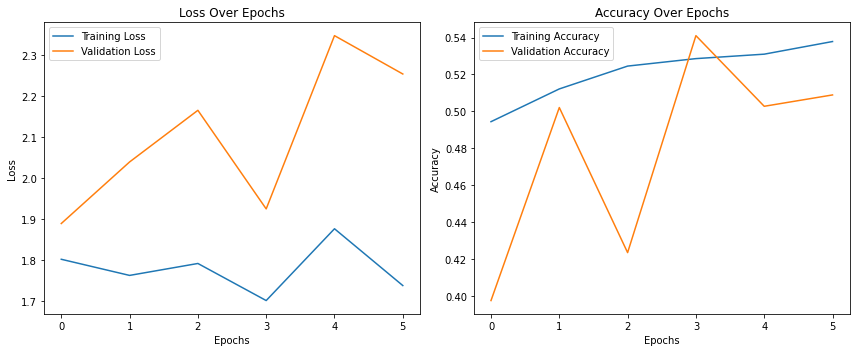

              precision    recall  f1-score   support

       anger     0.4488    0.3314    0.3813       516
     disgust     0.1701    0.2525    0.2033        99
        fear     0.2000    0.0833    0.1176        60
         joy     0.4580    0.3859    0.4189       495
     neutral     0.6489    0.8570    0.7385      1615
     sadness     0.0000    0.0000    0.0000       263
    surprise     0.4613    0.3892    0.4222       352

    accuracy                         0.5626      3400
   macro avg     0.3410    0.3285    0.3260      3400
weighted avg     0.4992    0.5626    0.5213      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [20]:
model = GCNWithSkipConnections(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)
show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
show_classification_report_model(model, test_loader)



Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 218.22it/s]


Epoch 1: Train Loss = 1.7492508570700012, Val Loss = 1.856125668860558, Train Acc = 0.5271806853582555, Val Acc = 0.5170998632010944


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.42it/s]


Epoch 2: Train Loss = 1.637171380173014, Val Loss = 2.0652782452741154, Train Acc = 0.5543613707165109, Val Acc = 0.4740082079343365


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 194.78it/s]


Epoch 3: Train Loss = 1.5649613887071845, Val Loss = 2.2420253039042883, Train Acc = 0.561993769470405, Val Acc = 0.5082079343365253


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.82it/s]


Epoch 4: Train Loss = 1.5161969228179766, Val Loss = 2.443564899350275, Train Acc = 0.5725077881619938, Val Acc = 0.5054719562243503


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.66it/s]


Epoch 5: Train Loss = 1.4889999173265769, Val Loss = 2.024183419561531, Train Acc = 0.5771028037383178, Val Acc = 0.4945280437756498


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.48it/s]


Epoch 6: Train Loss = 1.4204637973094645, Val Loss = 2.987373973452486, Train Acc = 0.5860591900311527, Val Acc = 0.5218878248974008
Early stopping triggered


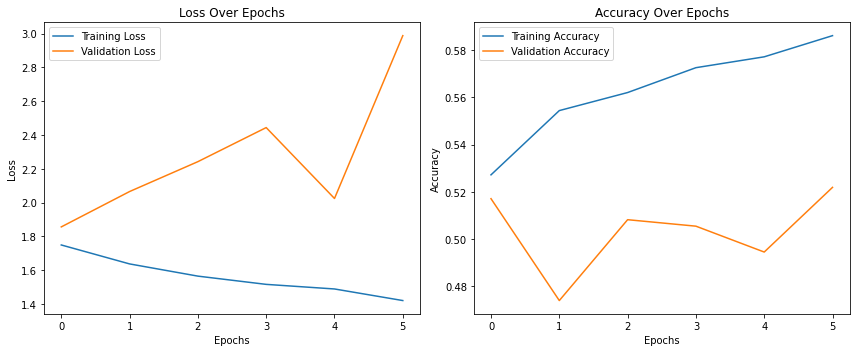

In [24]:
model = GCNWithConcatenation(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [25]:
show_classification_report_model(model, test_loader)

              precision    recall  f1-score   support

       anger     0.4244    0.4186    0.4215       516
     disgust     0.4167    0.0505    0.0901        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4792    0.3030    0.3713       495
     neutral     0.7201    0.7950    0.7557      1615
     sadness     0.3333    0.0114    0.0221       263
    surprise     0.3178    0.6989    0.4369       352

    accuracy                         0.5600      3400
   macro avg     0.3845    0.3254    0.2997      3400
weighted avg     0.5471    0.5600    0.5266      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

with tuning

In [26]:
best_model, best_params = tune_model(GCNWithSkipConnections, train_loader, val_loader, 768, 7)

Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.81it/s]


Epoch 1: Train Loss = 109.76933900498734, Val Loss = 115.52050697522814, Train Acc = 0.4116822429906542, Val Acc = 0.4069767441860465


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.73it/s]


Epoch 2: Train Loss = 130.48127408373549, Val Loss = 121.40128233587677, Train Acc = 0.45506230529595015, Val Acc = 0.46716826265389877


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.97it/s]


Epoch 3: Train Loss = 126.0080559912542, Val Loss = 108.09408511407484, Train Acc = 0.4680685358255452, Val Acc = 0.5136798905608755


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.77it/s]


Epoch 4: Train Loss = 121.49697059922899, Val Loss = 132.59506977065774, Train Acc = 0.4747663551401869, Val Acc = 0.3707250341997264


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.01it/s]


Epoch 5: Train Loss = 140.80349378796822, Val Loss = 205.34362300965446, Train Acc = 0.47235202492211836, Val Acc = 0.40013679890560877


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.64it/s]


Epoch 6: Train Loss = 145.52525723584105, Val Loss = 264.7760070582928, Train Acc = 0.47998442367601246, Val Acc = 0.4110807113543092


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.18it/s]


Epoch 7: Train Loss = 143.4242696585691, Val Loss = 148.82028344103298, Train Acc = 0.48629283489096575, Val Acc = 0.48084815321477425


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.75it/s]


Epoch 8: Train Loss = 135.34999225349446, Val Loss = 134.2657809516346, Train Acc = 0.4934579439252336, Val Acc = 0.5047879616963065
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.11it/s]


Epoch 1: Train Loss = 1.7879238588245816, Val Loss = 2.019625440190322, Train Acc = 0.4900311526479751, Val Acc = 0.5


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.50it/s]


Epoch 2: Train Loss = 1.8353050160785778, Val Loss = 1.800553387089598, Train Acc = 0.5200155763239875, Val Acc = 0.5150478796169631


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.01it/s]


Epoch 3: Train Loss = 1.727052835535294, Val Loss = 2.7139291669880214, Train Acc = 0.5275700934579439, Val Acc = 0.47674418604651164


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.46it/s]


Epoch 4: Train Loss = 1.8198895280719558, Val Loss = 1.8797662138111062, Train Acc = 0.5275700934579439, Val Acc = 0.5225718194254446


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.25it/s]


Epoch 5: Train Loss = 1.7927604640291706, Val Loss = 3.3824704669113057, Train Acc = 0.5327102803738317, Val Acc = 0.512311901504788


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.52it/s]


Epoch 6: Train Loss = 1.7266732781849121, Val Loss = 2.2758080659192745, Train Acc = 0.5373052959501557, Val Acc = 0.49247606019151846


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.50it/s]


Epoch 7: Train Loss = 1.7689798083285428, Val Loss = 2.075730349606386, Train Acc = 0.5431464174454829, Val Acc = 0.45896032831737343
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.97it/s]


Epoch 1: Train Loss = 1.7668336646957161, Val Loss = 1.9581880233629987, Train Acc = 0.4960280373831776, Val Acc = 0.4151846785225718


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.46it/s]


Epoch 2: Train Loss = 1.826127135577742, Val Loss = 1.8723926358241847, Train Acc = 0.513785046728972, Val Acc = 0.5383036935704515


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.70it/s]


Epoch 3: Train Loss = 1.7393013721469557, Val Loss = 1.667623442314841, Train Acc = 0.5310747663551402, Val Acc = 0.5410396716826266


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.47it/s]


Epoch 4: Train Loss = 1.7730182152253595, Val Loss = 1.831345522955612, Train Acc = 0.5320093457943925, Val Acc = 0.5109439124487004


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.20it/s]


Epoch 5: Train Loss = 1.7537293249203652, Val Loss = 2.187081475558915, Train Acc = 0.5402647975077881, Val Acc = 0.5232558139534884


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.46it/s]


Epoch 6: Train Loss = 1.7361972532886756, Val Loss = 2.0957780733169917, Train Acc = 0.5380062305295951, Val Acc = 0.5239398084815321


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.22it/s]


Epoch 7: Train Loss = 1.8566547455520894, Val Loss = 1.9792980792069876, Train Acc = 0.5350467289719626, Val Acc = 0.472640218878249


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.01it/s]


Epoch 8: Train Loss = 1.7078707798575261, Val Loss = 2.3952117110844013, Train Acc = 0.5428348909657321, Val Acc = 0.42339261285909713


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.42it/s]


Epoch 9: Train Loss = 1.8281942142299301, Val Loss = 2.0538340730868554, Train Acc = 0.5428348909657321, Val Acc = 0.5088919288645691


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.92it/s]


Epoch 10: Train Loss = 1.785920374777224, Val Loss = 2.1478961205834315, Train Acc = 0.5448598130841121, Val Acc = 0.46716826265389877


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.97it/s]


Epoch 11: Train Loss = 1.798319653198131, Val Loss = 2.7806050645325473, Train Acc = 0.5534267912772586, Val Acc = 0.3844049247606019


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.97it/s]


Epoch 12: Train Loss = 1.7692381637237997, Val Loss = 3.783670058929258, Train Acc = 0.5484423676012461, Val Acc = 0.320109439124487


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.50it/s]


Epoch 13: Train Loss = 1.7248105033281174, Val Loss = 2.857359197562457, Train Acc = 0.5550623052959501, Val Acc = 0.5225718194254446
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 211.38it/s]


Epoch 1: Train Loss = 1.196330589433718, Val Loss = 1.350406908457754, Train Acc = 0.5873052959501558, Val Acc = 0.554719562243502


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.79it/s]


Epoch 2: Train Loss = 1.090153406969168, Val Loss = 1.3187885000611896, Train Acc = 0.6166666666666667, Val Acc = 0.5403556771545828


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.45it/s]


Epoch 3: Train Loss = 1.058811659824655, Val Loss = 1.3342059748040305, Train Acc = 0.6193146417445483, Val Acc = 0.5615595075239398


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.84it/s]


Epoch 4: Train Loss = 1.0278402238601336, Val Loss = 1.2715003536462233, Train Acc = 0.6250778816199377, Val Acc = 0.5649794801641587


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.18it/s]


Epoch 5: Train Loss = 1.0020681992174272, Val Loss = 1.3614126732365952, Train Acc = 0.6337227414330218, Val Acc = 0.5704514363885089


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.76it/s]


Epoch 6: Train Loss = 0.9879416466924509, Val Loss = 1.3491490262422572, Train Acc = 0.6383177570093458, Val Acc = 0.5649794801641587


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.32it/s]


Epoch 7: Train Loss = 0.9702216450355114, Val Loss = 1.3878729190056522, Train Acc = 0.6393302180685358, Val Acc = 0.5725034199726402


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.69it/s]


Epoch 8: Train Loss = 0.9570237621996192, Val Loss = 1.4223920563304866, Train Acc = 0.6419781931464175, Val Acc = 0.5499316005471956


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.51it/s]


Epoch 9: Train Loss = 0.9383681951038954, Val Loss = 1.3417378749560427, Train Acc = 0.6483644859813084, Val Acc = 0.5526675786593708
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 206.32it/s]


Epoch 1: Train Loss = 1.2031124921877765, Val Loss = 1.3466347054750831, Train Acc = 0.5864485981308412, Val Acc = 0.5225718194254446


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.61it/s]


Epoch 2: Train Loss = 1.0943622959346544, Val Loss = 1.2716007898113242, Train Acc = 0.6145638629283489, Val Acc = 0.5683994528043775


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.91it/s]


Epoch 3: Train Loss = 1.0560357266726592, Val Loss = 1.3106808891657877, Train Acc = 0.6239096573208722, Val Acc = 0.579343365253078


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.01it/s]


Epoch 4: Train Loss = 1.0260701990951526, Val Loss = 1.3354176894727128, Train Acc = 0.6292834890965732, Val Acc = 0.5752393980848153


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.10it/s]


Epoch 5: Train Loss = 0.9978222165987568, Val Loss = 1.285248221139665, Train Acc = 0.6344236760124611, Val Acc = 0.56703146374829


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.97it/s]


Epoch 6: Train Loss = 0.9858490515439944, Val Loss = 1.315507403043685, Train Acc = 0.6340342679127726, Val Acc = 0.5690834473324213


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.74it/s]


Epoch 7: Train Loss = 0.9618085333312154, Val Loss = 1.3406127123369111, Train Acc = 0.6447040498442368, Val Acc = 0.5690834473324213
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.579343365253078


In [27]:
show_classification_report_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger     0.5785    0.2713    0.3694       516
     disgust     0.3684    0.2121    0.2692        99
        fear     0.3235    0.1833    0.2340        60
         joy     0.5344    0.3919    0.4522       495
     neutral     0.6544    0.9158    0.7634      1615
     sadness     0.5000    0.1445    0.2242       263
    surprise     0.4837    0.5057    0.4944       352

    accuracy                         0.6062      3400
   macro avg     0.4919    0.3749    0.4010      3400
weighted avg     0.5816    0.6062    0.5650      3400



In [28]:
best_model, best_params = tune_model(GCNWithConcatenation, train_loader, val_loader, 768, 7)

show_classification_report_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 214.24it/s]


Epoch 1: Train Loss = 1.7531163045247753, Val Loss = 1.869127548534285, Train Acc = 0.5271806853582555, Val Acc = 0.5287277701778386


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 196.64it/s]


Epoch 2: Train Loss = 1.6314553748358136, Val Loss = 1.9054938644239747, Train Acc = 0.555841121495327, Val Acc = 0.4945280437756498


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.14it/s]


Epoch 3: Train Loss = 1.5561153755343522, Val Loss = 2.0771330390466134, Train Acc = 0.5660436137071652, Val Acc = 0.5280437756497948


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.19it/s]


Epoch 4: Train Loss = 1.5718877475418325, Val Loss = 2.1057619944214823, Train Acc = 0.5756230529595016, Val Acc = 0.5540355677154583


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 135.89it/s]


Epoch 5: Train Loss = 1.4742764901483463, Val Loss = 2.4823903096839786, Train Acc = 0.5838785046728971, Val Acc = 0.5109439124487004


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 146.81it/s]


Epoch 6: Train Loss = 1.5123572342553047, Val Loss = 2.4161226410298022, Train Acc = 0.5821651090342679, Val Acc = 0.4637482900136799
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 205.59it/s]


Epoch 1: Train Loss = 1.1923819789869918, Val Loss = 1.2945499025699165, Train Acc = 0.592834890965732, Val Acc = 0.560875512995896


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.23it/s]


Epoch 2: Train Loss = 1.0749435117313018, Val Loss = 1.3177857472250858, Train Acc = 0.6223520249221184, Val Acc = 0.5779753761969905


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.46it/s]


Epoch 3: Train Loss = 1.0359795371898346, Val Loss = 1.3225054155207343, Train Acc = 0.6306853582554517, Val Acc = 0.5636114911080712


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.82it/s]


Epoch 4: Train Loss = 1.008138755432123, Val Loss = 1.3310678990074882, Train Acc = 0.6333333333333333, Val Acc = 0.5615595075239398


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 159.55it/s]


Epoch 5: Train Loss = 0.9837056458397354, Val Loss = 1.3080993145083388, Train Acc = 0.6378504672897196, Val Acc = 0.5786593707250342


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.63it/s]


Epoch 6: Train Loss = 0.9654030192563099, Val Loss = 1.303249922491334, Train Acc = 0.6402647975077882, Val Acc = 0.5745554035567716
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 209.80it/s]


Epoch 1: Train Loss = 13.84411869737352, Val Loss = 18.015175811322404, Train Acc = 0.48457943925233643, Val Acc = 0.35225718194254446


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.47it/s]


Epoch 2: Train Loss = 13.29874923818074, Val Loss = 19.078062176266055, Train Acc = 0.5125389408099689, Val Acc = 0.533515731874145


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.93it/s]


Epoch 3: Train Loss = 12.943174766706534, Val Loss = 18.123148330838173, Train Acc = 0.5200934579439253, Val Acc = 0.493844049247606


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.40it/s]


Epoch 4: Train Loss = 12.235163221013815, Val Loss = 23.093250503409077, Train Acc = 0.5327102803738317, Val Acc = 0.37756497948016415


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.49it/s]


Epoch 5: Train Loss = 12.88588168744853, Val Loss = 18.7455822631612, Train Acc = 0.540576323987539, Val Acc = 0.4829001367989056


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.60it/s]


Epoch 6: Train Loss = 12.206253647915453, Val Loss = 25.788011710660506, Train Acc = 0.5512461059190031, Val Acc = 0.454172366621067


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.46it/s]


Epoch 7: Train Loss = 12.330787904306227, Val Loss = 20.756086908373824, Train Acc = 0.5478971962616822, Val Acc = 0.4377564979480164


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.34it/s]


Epoch 8: Train Loss = 12.298707144852754, Val Loss = 25.363689013729633, Train Acc = 0.5498442367601246, Val Acc = 0.3372093023255814


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.57it/s]


Epoch 9: Train Loss = 12.307470978969514, Val Loss = 22.955507101223954, Train Acc = 0.5562305295950156, Val Acc = 0.5027359781121751


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.10it/s]


Epoch 10: Train Loss = 11.729397148098906, Val Loss = 29.974014649850343, Train Acc = 0.5629283489096574, Val Acc = 0.46443228454172364


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.28it/s]


Epoch 11: Train Loss = 11.832882611108557, Val Loss = 16.894966509827807, Train Acc = 0.5750778816199377, Val Acc = 0.46169630642954856


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.36it/s]


Epoch 12: Train Loss = 11.90478631990526, Val Loss = 25.36550683168883, Train Acc = 0.5609034267912772, Val Acc = 0.4794801641586867


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.28it/s]


Epoch 13: Train Loss = 11.625369251883347, Val Loss = 23.349767416284912, Train Acc = 0.5698598130841122, Val Acc = 0.4719562243502052


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.23it/s]


Epoch 14: Train Loss = 12.393279422333118, Val Loss = 22.801286059481352, Train Acc = 0.5700934579439252, Val Acc = 0.5102599179206566


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.99it/s]


Epoch 15: Train Loss = 11.895132673785666, Val Loss = 25.218731020007546, Train Acc = 0.5643302180685358, Val Acc = 0.5164158686730507


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.73it/s]


Epoch 16: Train Loss = 11.45640304309858, Val Loss = 20.42200737132277, Train Acc = 0.569158878504673, Val Acc = 0.5205198358413132


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.76it/s]


Epoch 17: Train Loss = 12.019406829896624, Val Loss = 19.647269418939487, Train Acc = 0.5749221183800624, Val Acc = 0.5136798905608755


Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.71it/s]


Epoch 18: Train Loss = 11.703462131171342, Val Loss = 19.065521087922914, Train Acc = 0.575778816199377, Val Acc = 0.5615595075239398


Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.97it/s]


Epoch 19: Train Loss = 11.595366614589409, Val Loss = 19.57015510166911, Train Acc = 0.5777258566978193, Val Acc = 0.4685362517099863


Epoch 20: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.12it/s]


Epoch 20: Train Loss = 11.219891274741306, Val Loss = 20.82343639815809, Train Acc = 0.5774143302180685, Val Acc = 0.46169630642954856


Epoch 21: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.62it/s]


Epoch 21: Train Loss = 11.675785650599583, Val Loss = 24.58512007937494, Train Acc = 0.5813084112149532, Val Acc = 0.39740082079343364
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 209.72it/s]


Epoch 1: Train Loss = 1.7704635708501748, Val Loss = 2.0924192250546723, Train Acc = 0.5299844236760125, Val Acc = 0.521203830369357


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.77it/s]


Epoch 2: Train Loss = 1.624716903450341, Val Loss = 2.1671071202347605, Train Acc = 0.5529595015576324, Val Acc = 0.5581395348837209


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.25it/s]


Epoch 3: Train Loss = 1.5637158521273873, Val Loss = 2.515814521776607, Train Acc = 0.5653426791277258, Val Acc = 0.4883720930232558


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.97it/s]


Epoch 4: Train Loss = 1.5117888277043137, Val Loss = 2.2370240742340686, Train Acc = 0.5712616822429907, Val Acc = 0.5205198358413132


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.06it/s]


Epoch 5: Train Loss = 1.4759255088737873, Val Loss = 2.538577045139391, Train Acc = 0.5774922118380063, Val Acc = 0.49316005471956226


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.46it/s]


Epoch 6: Train Loss = 1.481137599289239, Val Loss = 2.321666803461051, Train Acc = 0.5790498442367601, Val Acc = 0.5129958960328317


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.64it/s]


Epoch 7: Train Loss = 1.3997390968892756, Val Loss = 2.04438534743601, Train Acc = 0.5894859813084112, Val Acc = 0.4911080711354309


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.52it/s]


Epoch 8: Train Loss = 1.4292236599710324, Val Loss = 3.2766988398369263, Train Acc = 0.5863707165109034, Val Acc = 0.42886456908344733


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.77it/s]


Epoch 9: Train Loss = 1.4043397668693918, Val Loss = 2.7051966125770477, Train Acc = 0.5940031152647975, Val Acc = 0.4993160054719562


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.78it/s]


Epoch 10: Train Loss = 1.4297591367254763, Val Loss = 2.3870030889632523, Train Acc = 0.5951713395638629, Val Acc = 0.49247606019151846


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.08it/s]


Epoch 11: Train Loss = 1.3869423973345505, Val Loss = 2.2922385109276986, Train Acc = 0.5982866043613707, Val Acc = 0.5232558139534884


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.86it/s]


Epoch 12: Train Loss = 1.3530855788192655, Val Loss = 2.4885752195992543, Train Acc = 0.5993769470404985, Val Acc = 0.5095759233926128


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.51it/s]


Epoch 13: Train Loss = 1.3915508462430404, Val Loss = 2.2306830804010302, Train Acc = 0.5995327102803738, Val Acc = 0.4993160054719562


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.11it/s]


Epoch 14: Train Loss = 1.3605498228329822, Val Loss = 3.151696669638019, Train Acc = 0.6021806853582554, Val Acc = 0.42339261285909713


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.43it/s]


Epoch 15: Train Loss = 1.3551942275720446, Val Loss = 2.8872580203555387, Train Acc = 0.6041277258566978, Val Acc = 0.5020519835841313


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.02it/s]


Epoch 16: Train Loss = 1.3775825202790624, Val Loss = 2.5704871354141723, Train Acc = 0.6077881619937695, Val Acc = 0.466484268125855


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.67it/s]


Epoch 17: Train Loss = 1.3441295344719184, Val Loss = 2.9755464254343815, Train Acc = 0.6050623052959502, Val Acc = 0.5068399452804377
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 224.38it/s]


Epoch 1: Train Loss = 1.1958575748993705, Val Loss = 1.3095125050456435, Train Acc = 0.5908878504672898, Val Acc = 0.5485636114911081


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 210.01it/s]


Epoch 2: Train Loss = 1.0817744114186132, Val Loss = 1.2984576475289134, Train Acc = 0.6211059190031153, Val Acc = 0.5704514363885089


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 201.50it/s]


Epoch 3: Train Loss = 1.0432683544190324, Val Loss = 1.3203532423686097, Train Acc = 0.6258566978193146, Val Acc = 0.5629274965800274


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.70it/s]


Epoch 4: Train Loss = 1.012284272947107, Val Loss = 1.30825896806739, Train Acc = 0.6324766355140187, Val Acc = 0.5554035567715458


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.72it/s]


Epoch 5: Train Loss = 0.9894045155225926, Val Loss = 1.3322898854811986, Train Acc = 0.6383956386292835, Val Acc = 0.5499316005471956


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.73it/s]


Epoch 6: Train Loss = 0.9726694336902626, Val Loss = 1.3038773336344296, Train Acc = 0.640031152647975, Val Acc = 0.5711354309165527


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.21it/s]


Epoch 7: Train Loss = 0.9571500811372298, Val Loss = 1.3236914135791638, Train Acc = 0.6446261682242991, Val Acc = 0.5663474692202463
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5786593707250342
              precision    recall  f1-score   support

       anger     0.5677    0.3818    0.4565       516
     disgust     0.3194    0.2323    0.2690        99
        fear     0.3846    0.0833    0.1370        60
         joy     0.5533    0.4505    0.4967       495
     neutral     0.6933    0.8805    0.7758      1615
     sadness     0.4362    0.1559    0.2297       263
    surprise     0.4357    0.5199    0.4741       352

    accuracy                         0.6159      3400
   macro avg     0.4843    0.3863    0.4055      3400
weighted avg     0.5910    0.6159    0.5872      3400



#### Get the predicted labels for later analysis

In [23]:
model = GCNWithConcatenation(768, 7)
model, _, _, _, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    lr=0.001,
    num_epochs=30,
    early_stop_threshold=0.001,
    max_no_improve_epochs=5
)

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:08<00:00, 244.38it/s]


Epoch 1: Train Loss = 1.1952164671383798, Val Loss = 1.2895852208137513, Train Acc = 0.5908878504672898, Val Acc = 0.5642954856361149


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 221.31it/s]


Epoch 2: Train Loss = 1.078140998906801, Val Loss = 1.3388077740867932, Train Acc = 0.6225856697819314, Val Acc = 0.5718194254445964


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 214.84it/s]


Epoch 3: Train Loss = 1.038844828205873, Val Loss = 1.2887273901728569, Train Acc = 0.6281152647975078, Val Acc = 0.5738714090287278


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 211.38it/s]


Epoch 4: Train Loss = 1.0098759817511396, Val Loss = 1.293659818807134, Train Acc = 0.6305295950155764, Val Acc = 0.579343365253078


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.08it/s]


Epoch 5: Train Loss = 0.9844934186949912, Val Loss = 1.2946041829884052, Train Acc = 0.6373831775700934, Val Acc = 0.5697674418604651


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 150.77it/s]


Epoch 6: Train Loss = 0.9680973256532862, Val Loss = 1.3104419021970697, Train Acc = 0.6413551401869159, Val Acc = 0.5766073871409029
Early stopping triggered


NameError: name 'all_predictions' is not defined

In [27]:
show_classification_report_model(model, test_loader)

              precision    recall  f1-score   support

       anger     0.5163    0.4593    0.4862       516
     disgust     0.5333    0.0808    0.1404        99
        fear     0.6000    0.0500    0.0923        60
         joy     0.5683    0.4707    0.5149       495
     neutral     0.6860    0.8916    0.7754      1615
     sadness     0.4020    0.1559    0.2247       263
    surprise     0.5290    0.4659    0.4955       352

    accuracy                         0.6253      3400
   macro avg     0.5479    0.3678    0.3899      3400
weighted avg     0.5989    0.6253    0.5915      3400



#### RGCN

In [32]:
def train_relational_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index , data.edge_type)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.edge_type)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_relation_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_relational_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_classification_report_relation_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())


    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(),digits = 4))

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 111.86it/s]


Epoch 1: Train Loss = 1.7486440838218849, Val Loss = 1.7557173054803301, Train Acc = 0.49805295950155765, Val Acc = 0.4370725034199726


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.08it/s]


Epoch 2: Train Loss = 1.8337227982086106, Val Loss = 1.804327254249128, Train Acc = 0.5193925233644859, Val Acc = 0.5054719562243503


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.27it/s]


Epoch 3: Train Loss = 1.715528488397831, Val Loss = 2.17002001720043, Train Acc = 0.5237538940809969, Val Acc = 0.5027359781121751


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.60it/s]


Epoch 4: Train Loss = 1.8330631837702067, Val Loss = 2.210954057814174, Train Acc = 0.5242990654205607, Val Acc = 0.47674418604651164


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.66it/s]


Epoch 5: Train Loss = 1.8522021627421188, Val Loss = 1.8768585057170302, Train Acc = 0.5324766355140187, Val Acc = 0.43091655266757867


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.94it/s]


Epoch 6: Train Loss = 1.8559022164251529, Val Loss = 1.817906469617177, Train Acc = 0.533411214953271, Val Acc = 0.5
Early stopping triggered


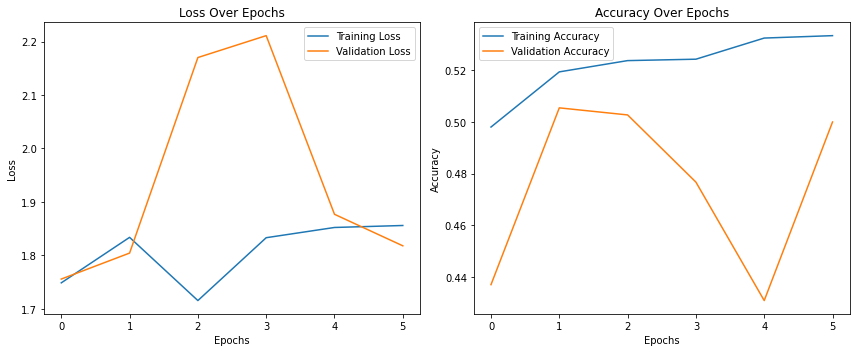

              precision    recall  f1-score   support

       anger     0.8333    0.1260    0.2189       516
     disgust     0.2021    0.1919    0.1969        99
        fear     0.0966    0.2833    0.1441        60
         joy     0.4441    0.2727    0.3379       495
     neutral     0.5954    0.8539    0.7016      1615
     sadness     0.2663    0.1711    0.2083       263
    surprise     0.5627    0.4205    0.4813       352

    accuracy                         0.5318      3400
   macro avg     0.4287    0.3313    0.3270      3400
weighted avg     0.5604    0.5318    0.4899      3400



In [33]:
model = RGCNWithGAT(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [34]:
best_model, best_params = tune_relation_model(RGCNWithGAT, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 114.27it/s]


Epoch 1: Train Loss = 1.751631284190457, Val Loss = 1.9199419052814375, Train Acc = 0.4937694704049844, Val Acc = 0.478796169630643


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.94it/s]


Epoch 2: Train Loss = 1.8479100191087734, Val Loss = 2.6867626169213543, Train Acc = 0.5143302180685358, Val Acc = 0.3967168262653899


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.51it/s]


Epoch 3: Train Loss = 1.7809574578710925, Val Loss = 2.045004030026461, Train Acc = 0.5191588785046729, Val Acc = 0.5348837209302325


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.91it/s]


Epoch 4: Train Loss = 1.8048691801312375, Val Loss = 3.120524926929499, Train Acc = 0.5292056074766355, Val Acc = 0.5095759233926128


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.19it/s]


Epoch 5: Train Loss = 1.783519357735521, Val Loss = 1.901803613026385, Train Acc = 0.5422897196261682, Val Acc = 0.5273597811217511


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.56it/s]


Epoch 6: Train Loss = 1.7492562559760114, Val Loss = 2.0014033807432967, Train Acc = 0.5429906542056074, Val Acc = 0.542407660738714


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.34it/s]


Epoch 7: Train Loss = 1.7681388673890979, Val Loss = 2.386280431425958, Train Acc = 0.5462616822429907, Val Acc = 0.5287277701778386


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.47it/s]


Epoch 8: Train Loss = 1.7386750656806624, Val Loss = 2.369145675715387, Train Acc = 0.5426791277258567, Val Acc = 0.5136798905608755


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.92it/s]


Epoch 9: Train Loss = 1.7418639165046477, Val Loss = 2.2064459956561526, Train Acc = 0.5499221183800623, Val Acc = 0.478796169630643


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.28it/s]


Epoch 10: Train Loss = 1.7621642235897812, Val Loss = 2.287985965356455, Train Acc = 0.5516355140186916, Val Acc = 0.5116279069767442


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.30it/s]


Epoch 11: Train Loss = 1.7557710927589205, Val Loss = 2.8618750331716405, Train Acc = 0.5526479750778817, Val Acc = 0.41997264021887826


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.26it/s]


Epoch 12: Train Loss = 1.7763787724751672, Val Loss = 2.50441386468743, Train Acc = 0.553816199376947, Val Acc = 0.46990424076607384


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.88it/s]


Epoch 13: Train Loss = 1.8020150370212227, Val Loss = 2.675532792741433, Train Acc = 0.5492990654205607, Val Acc = 0.5198358413132695


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.77it/s]


Epoch 14: Train Loss = 1.7649661392039855, Val Loss = 2.3406301460599663, Train Acc = 0.5562305295950156, Val Acc = 0.5218878248974008


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.88it/s]


Epoch 15: Train Loss = 1.7628849103218867, Val Loss = 3.028073769306219, Train Acc = 0.5566199376947041, Val Acc = 0.4993160054719562
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 108.70it/s]


Epoch 1: Train Loss = 1.8208734785148812, Val Loss = 2.1096929515303433, Train Acc = 0.48862928348909657, Val Acc = 0.5054719562243503


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.96it/s]


Epoch 2: Train Loss = 1.734326497338932, Val Loss = 2.527887776043887, Train Acc = 0.5189252336448598, Val Acc = 0.48632010943912446


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.75it/s]


Epoch 3: Train Loss = 1.7624549036092705, Val Loss = 1.8162741846741282, Train Acc = 0.5264018691588785, Val Acc = 0.5164158686730507


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 102.32it/s]


Epoch 4: Train Loss = 1.7404555304983322, Val Loss = 2.7341120280428894, Train Acc = 0.5324766355140187, Val Acc = 0.3645690834473324


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.10it/s]


Epoch 5: Train Loss = 1.984297378124514, Val Loss = 2.5258412623467543, Train Acc = 0.5328660436137072, Val Acc = 0.4883720930232558


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.94it/s]


Epoch 6: Train Loss = 1.6689702666488166, Val Loss = 2.660997520552741, Train Acc = 0.5419003115264798, Val Acc = 0.4179206566347469


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.77it/s]


Epoch 7: Train Loss = 1.7453385729198527, Val Loss = 2.5738952503832815, Train Acc = 0.5439252336448598, Val Acc = 0.49247606019151846


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.18it/s]


Epoch 8: Train Loss = 1.862459184608379, Val Loss = 2.2093429661562873, Train Acc = 0.5313862928348909, Val Acc = 0.5136798905608755
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 108.89it/s]


Epoch 1: Train Loss = 109.96996858847247, Val Loss = 281.3864661985543, Train Acc = 0.413785046728972, Val Acc = 0.41450068399452805


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.63it/s]


Epoch 2: Train Loss = 118.66773720878082, Val Loss = 125.67973465951061, Train Acc = 0.45093457943925236, Val Acc = 0.420656634746922


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.27it/s]


Epoch 3: Train Loss = 125.71852667198874, Val Loss = 167.14743774202134, Train Acc = 0.4651869158878505, Val Acc = 0.2606019151846785


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.75it/s]


Epoch 4: Train Loss = 127.68599398247243, Val Loss = 115.08916732359816, Train Acc = 0.475, Val Acc = 0.43091655266757867


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.12it/s]


Epoch 5: Train Loss = 136.76305346117883, Val Loss = 117.85477579566968, Train Acc = 0.4829439252336449, Val Acc = 0.5191518467852257


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.83it/s]


Epoch 6: Train Loss = 139.57035233908294, Val Loss = 243.917116376998, Train Acc = 0.4855140186915888, Val Acc = 0.353625170998632


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.58it/s]


Epoch 7: Train Loss = 138.32723281443478, Val Loss = 198.42667045725716, Train Acc = 0.49898753894081, Val Acc = 0.38235294117647056


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.94it/s]


Epoch 8: Train Loss = 149.44465486850328, Val Loss = 198.4938754585054, Train Acc = 0.4894859813084112, Val Acc = 0.34746922024623805


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.21it/s]


Epoch 9: Train Loss = 153.87472642145306, Val Loss = 134.91282513367835, Train Acc = 0.5024143302180686, Val Acc = 0.4322845417236662
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 109.93it/s]


Epoch 1: Train Loss = 96.5702566996979, Val Loss = 91.94584183869539, Train Acc = 0.40708722741433023, Val Acc = 0.45348837209302323


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.97it/s]


Epoch 2: Train Loss = 163.2301862700018, Val Loss = 122.6911721299575, Train Acc = 0.4585669781931464, Val Acc = 0.5218878248974008


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.00it/s]


Epoch 3: Train Loss = 108.09719809111918, Val Loss = 140.432518428502, Train Acc = 0.4664330218068536, Val Acc = 0.46716826265389877


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.51it/s]


Epoch 4: Train Loss = 133.42771027725732, Val Loss = 132.12227708829772, Train Acc = 0.4735202492211838, Val Acc = 0.45143638850889195


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.19it/s]


Epoch 5: Train Loss = 133.0817498934942, Val Loss = 154.58326378341812, Train Acc = 0.47757009345794393, Val Acc = 0.512311901504788


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 98.16it/s]


Epoch 6: Train Loss = 145.67859370809285, Val Loss = 149.3190114950876, Train Acc = 0.4866822429906542, Val Acc = 0.466484268125855
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 110.93it/s]


Epoch 1: Train Loss = 96.83835792994532, Val Loss = 164.66450026730294, Train Acc = 0.4062305295950156, Val Acc = 0.36114911080711354


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.55it/s]


Epoch 2: Train Loss = 135.4035636485012, Val Loss = 96.8919022708897, Train Acc = 0.45537383177570095, Val Acc = 0.43912448700410395


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.44it/s]


Epoch 3: Train Loss = 120.38794993550034, Val Loss = 109.45452479161436, Train Acc = 0.46269470404984425, Val Acc = 0.4418604651162791


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.77it/s]


Epoch 4: Train Loss = 124.14097496545847, Val Loss = 117.66354416432205, Train Acc = 0.4721183800623053, Val Acc = 0.49863201094391246


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.41it/s]


Epoch 5: Train Loss = 131.938646440652, Val Loss = 220.4993756325156, Train Acc = 0.47710280373831776, Val Acc = 0.3850889192886457


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.65it/s]


Epoch 6: Train Loss = 133.6878737283434, Val Loss = 117.7499486779093, Train Acc = 0.4881619937694704, Val Acc = 0.4781121751025992


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.40it/s]


Epoch 7: Train Loss = 149.47656098124094, Val Loss = 145.6793237472022, Train Acc = 0.4853582554517134, Val Acc = 0.5136798905608755
Early stopping triggered
Best params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.542407660738714
              precision    recall  f1-score   support

       anger     0.7778    0.0543    0.1014       516
     disgust     0.1490    0.3131    0.2020        99
        fear     0.3704    0.1667    0.2299        60
         joy     0.3202    0.6545    0.4300       495
     neutral     0.6800    0.8130    0.7406      1615
     sadness     0.3667    0.0837    0.1362       263
    surprise     0.7063    0.2528    0.3724       352

    accuracy                         0.5344      3400
   macro avg     0.4815    0.3340    0.3161      3400
weighted avg     0.6000    0.5344    0.4888      3400



#### RGAT

In [35]:
model = RGATWithSkipConnections(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:18<00:00, 15.56it/s]


Epoch 1: Train Loss = 229.9331735249666, Val Loss = 167.52960071916934, Train Acc = 0.2882398753894081, Val Acc = 0.4103967168262654


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:19<00:00, 15.46it/s]


Epoch 2: Train Loss = 412.5235233909513, Val Loss = 161.77749116603968, Train Acc = 0.3302180685358255, Val Acc = 0.45554035567715456


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:34<00:00, 13.96it/s]


Epoch 3: Train Loss = 434.47780673064057, Val Loss = 337.434800296651, Train Acc = 0.3572429906542056, Val Acc = 0.32489740082079344


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:37<00:00, 13.67it/s]


Epoch 4: Train Loss = 396.96715641414295, Val Loss = 285.0591537218403, Train Acc = 0.3820093457943925, Val Acc = 0.426812585499316


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:16<00:00, 15.87it/s]


Epoch 5: Train Loss = 213.41134072765928, Val Loss = 83.78796959995795, Train Acc = 0.36978193146417443, Val Acc = 0.4719562243502052


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:14<00:00, 16.03it/s]


Epoch 6: Train Loss = 531.8378229376094, Val Loss = 119.89230195019394, Train Acc = 0.336993769470405, Val Acc = 0.40834473324213405


Epoch 7:  64%|████████████████████████████████████████████▍                        | 1391/2160 [01:28<00:48, 15.70it/s]


KeyboardInterrupt: 

In [ ]:
best_model, best_params = tune_relation_model(RGATWithSkipConnections, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

#### EdgeGAT

In [36]:
DIOLOG_ID = 0
startIdx, endIdx = rangesTrain[DIOLOG_ID][0], rangesTrain[DIOLOG_ID][1]

graph = dgl.graph((edgeIndicesTrain[DIOLOG_ID][0], edgeIndicesTrain[DIOLOG_ID][1]))
edge_feats = get_ohe(edgeTypesTrain[DIOLOG_ID])

# egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)

In [37]:
graph

Graph(num_nodes=14, num_edges=50,
      ndata_schemes={}
      edata_schemes={})

In [38]:
class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out
            
class EdgeGATWithSkipConnection(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithSkipConnection, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        # Add self-loops to edge_index and adjust edge_attr accordingly if needed
#         print(f"nfeats shape: {nfeats.shape}")
        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
#         print(f"X shape: {x.shape}")
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
#         print(x.shape, " vs ", x_skip.shape)
        x += x_skip  # Add skip connection
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
class EdgeGATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        
#         # EGAT layer 2
#         x, e = self.egat2(graph, x, e)
#         x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data
    
class Edge2GATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(Edge2GATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data

In [39]:
def train_egat_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0


        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x, edge_feats)

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out = model(graph, data.x , edge_feats)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_egat_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_egat_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_egat_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x , edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    
    if key:
        df_predictions = pd.DataFrame({
            'true_label': all_labels,
            'predicted_label': all_predictions
        })

        file_name = f"data/dump/{dataset_path}/BERT_data_for_classifier/EGAT_predictedTest.pkl"
        with open(file_name, 'wb') as file:
            pickle.dump(df_predictions, file)
        
    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(), digits=4))

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.04it/s]


Epoch 1: Train Loss = 1.7508169311636435, Val Loss = 2.4477199243441983, Train Acc = 0.4928348909657321, Val Acc = 0.4835841313269494


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 51.65it/s]


Epoch 2: Train Loss = 1.8614587267601126, Val Loss = 2.0196849962709367, Train Acc = 0.5158878504672897, Val Acc = 0.5082079343365253


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:44<00:00, 48.80it/s]


Epoch 3: Train Loss = 1.7121979999998682, Val Loss = 2.3143716304252546, Train Acc = 0.5260124610591901, Val Acc = 0.45896032831737343


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:45<00:00, 47.41it/s]


Epoch 4: Train Loss = 1.9851188396778798, Val Loss = 2.2223041560845793, Train Acc = 0.527803738317757, Val Acc = 0.44596443228454175


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:43<00:00, 50.22it/s]


Epoch 5: Train Loss = 1.7762111288353684, Val Loss = 1.8626135133362065, Train Acc = 0.5386292834890966, Val Acc = 0.5444596443228454


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.09it/s]


Epoch 6: Train Loss = 1.8526075752794824, Val Loss = 1.9892977891783057, Train Acc = 0.5411993769470405, Val Acc = 0.5041039671682627


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 51.33it/s]


Epoch 7: Train Loss = 1.7611929413496774, Val Loss = 2.397973652716394, Train Acc = 0.5394859813084112, Val Acc = 0.5116279069767442


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 51.46it/s]


Epoch 8: Train Loss = 1.7543098490215003, Val Loss = 2.2826404740688977, Train Acc = 0.5468847352024923, Val Acc = 0.49794801641586867


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:43<00:00, 49.67it/s]


Epoch 9: Train Loss = 1.8448341377492734, Val Loss = 2.5674883072505947, Train Acc = 0.5355140186915888, Val Acc = 0.47058823529411764


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:44<00:00, 48.85it/s]


Epoch 10: Train Loss = 1.8134510760989828, Val Loss = 2.4652204876092987, Train Acc = 0.5484423676012461, Val Acc = 0.5198358413132695
Early stopping triggered


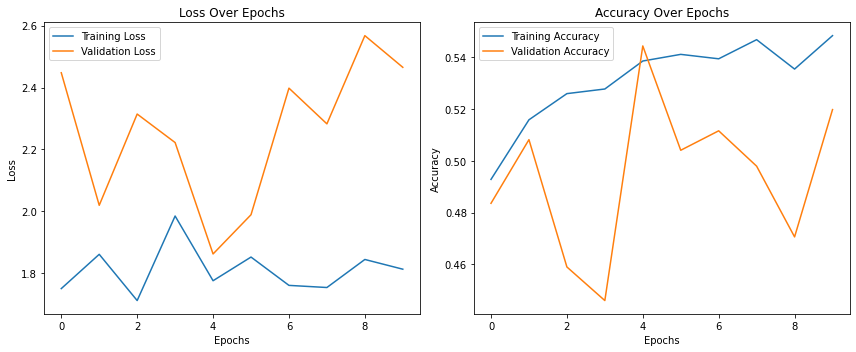

              precision    recall  f1-score   support

       anger     0.5802    0.1822    0.2773       516
     disgust     0.0000    0.0000    0.0000        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4417    0.4667    0.4538       495
     neutral     0.6609    0.8266    0.7345      1615
     sadness     0.1980    0.3004    0.2387       263
    surprise     0.5222    0.4347    0.4744       352

    accuracy                         0.5565      3400
   macro avg     0.3433    0.3158    0.3112      3400
weighted avg     0.5357    0.5565    0.5246      3400



In [40]:
model = EdgeGATWithSkipConnection(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
# model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_egat_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_egat_model(model, test_loader)

In [41]:
best_model, best_params = tune_egat_model(EdgeGATWithSkipConnection, train_loader, val_loader, 768, 3, 4)

Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.74it/s]


Epoch 1: Train Loss = 1.2530427348989717, Val Loss = 1.2929603115276054, Train Acc = 0.570404984423676, Val Acc = 0.5629274965800274


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.59it/s]


Epoch 2: Train Loss = 1.1198797624540964, Val Loss = 1.2761472565156442, Train Acc = 0.6124610591900311, Val Acc = 0.5636114911080712


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.72it/s]


Epoch 3: Train Loss = 1.0741569534573634, Val Loss = 1.2762124456189297, Train Acc = 0.6225077881619938, Val Acc = 0.5690834473324213


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.70it/s]


Epoch 4: Train Loss = 1.0448868925338266, Val Loss = 1.3052043095231056, Train Acc = 0.6338785046728972, Val Acc = 0.5663474692202463


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.86it/s]


Epoch 5: Train Loss = 1.0255470375677018, Val Loss = 1.3028900733631519, Train Acc = 0.6346573208722741, Val Acc = 0.5704514363885089


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.93it/s]


Epoch 6: Train Loss = 1.013110232634332, Val Loss = 1.3005554739385843, Train Acc = 0.6373831775700934, Val Acc = 0.5690834473324213


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.48it/s]


Epoch 7: Train Loss = 0.9971951349983337, Val Loss = 1.3958674412324197, Train Acc = 0.6440031152647975, Val Acc = 0.5629274965800274
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.33it/s]


Epoch 1: Train Loss = 1.2730445720100154, Val Loss = 1.3946579592647377, Train Acc = 0.5705607476635514, Val Acc = 0.512311901504788


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.31it/s]


Epoch 2: Train Loss = 1.1863017544749677, Val Loss = 1.4355302694908998, Train Acc = 0.5945482866043613, Val Acc = 0.5554035567715458


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.52it/s]


Epoch 3: Train Loss = 1.158840417932219, Val Loss = 1.4261496480968263, Train Acc = 0.596183800623053, Val Acc = 0.49726402188782487


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.74it/s]


Epoch 4: Train Loss = 1.1249990267937795, Val Loss = 1.3461109606066235, Train Acc = 0.6041277258566978, Val Acc = 0.5533515731874145


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.06it/s]


Epoch 5: Train Loss = 1.1152049527253474, Val Loss = 1.4620247502500812, Train Acc = 0.6066978193146417, Val Acc = 0.539671682626539


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.65it/s]


Epoch 6: Train Loss = 1.1155433211829169, Val Loss = 1.4596491486455003, Train Acc = 0.608411214953271, Val Acc = 0.5554035567715458


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.43it/s]


Epoch 7: Train Loss = 1.1004621317911962, Val Loss = 1.364614476201435, Train Acc = 0.6088006230529595, Val Acc = 0.5615595075239398


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.39it/s]


Epoch 8: Train Loss = 1.090957066000448, Val Loss = 1.5193047334060625, Train Acc = 0.608177570093458, Val Acc = 0.5437756497948016


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.85it/s]


Epoch 9: Train Loss = 1.0814295411161665, Val Loss = 1.482150282069213, Train Acc = 0.6140186915887851, Val Acc = 0.5253077975376197
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.88it/s]


Epoch 1: Train Loss = 4.6547127997704285, Val Loss = 3.530129075505667, Train Acc = 0.3691588785046729, Val Acc = 0.3112175102599179


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.30it/s]


Epoch 2: Train Loss = 4.915990390624463, Val Loss = 2.879628027582334, Train Acc = 0.37461059190031154, Val Acc = 0.4076607387140903


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.47it/s]


Epoch 3: Train Loss = 5.698960134506766, Val Loss = 10.640638798668428, Train Acc = 0.36752336448598133, Val Acc = 0.17852257181942544


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.94it/s]


Epoch 4: Train Loss = 4.594484612117774, Val Loss = 7.914586770764544, Train Acc = 0.37982866043613706, Val Acc = 0.3967168262653899


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.00it/s]


Epoch 5: Train Loss = 4.2896996407157095, Val Loss = 6.466199060777823, Train Acc = 0.3856697819314642, Val Acc = 0.2448700410396717


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.05it/s]


Epoch 6: Train Loss = 5.545597281734507, Val Loss = 2.9138275434628533, Train Acc = 0.37398753894081, Val Acc = 0.4261285909712722


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.31it/s]


Epoch 7: Train Loss = 3.9438975340009974, Val Loss = 4.090868433066471, Train Acc = 0.3927570093457944, Val Acc = 0.35704514363885087


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.68it/s]


Epoch 8: Train Loss = 5.761571473785764, Val Loss = 3.9177605270120828, Train Acc = 0.38403426791277256, Val Acc = 0.43296853625171


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.08it/s]


Epoch 9: Train Loss = 5.0326293007077245, Val Loss = 3.6077234156843687, Train Acc = 0.3888629283489097, Val Acc = 0.40287277701778385


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.54it/s]


Epoch 10: Train Loss = 4.547194882138753, Val Loss = 5.5593430654318245, Train Acc = 0.38979750778816197, Val Acc = 0.213406292749658


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.45it/s]


Epoch 11: Train Loss = 5.646514177990798, Val Loss = 14.268975835528087, Train Acc = 0.39478193146417445, Val Acc = 0.09917920656634747


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.43it/s]


Epoch 12: Train Loss = 5.11332032193835, Val Loss = 5.574632925788562, Train Acc = 0.3886292834890966, Val Acc = 0.23666210670314639
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.01it/s]


Epoch 1: Train Loss = 1.2729117271162707, Val Loss = 1.396003939266558, Train Acc = 0.5693146417445483, Val Acc = 0.5116279069767442


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.05it/s]


Epoch 2: Train Loss = 1.186070354722216, Val Loss = 1.4415165309552793, Train Acc = 0.5943146417445483, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.04it/s]


Epoch 3: Train Loss = 1.1587493212035582, Val Loss = 1.4192812414081009, Train Acc = 0.596183800623053, Val Acc = 0.5006839945280438


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.50it/s]


Epoch 4: Train Loss = 1.1246831640894352, Val Loss = 1.346560258825344, Train Acc = 0.6036604361370717, Val Acc = 0.551983584131327


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.20it/s]


Epoch 5: Train Loss = 1.1151699193813667, Val Loss = 1.4610833651420694, Train Acc = 0.6072429906542056, Val Acc = 0.539671682626539


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.36it/s]


Epoch 6: Train Loss = 1.1154523087833594, Val Loss = 1.460460332194688, Train Acc = 0.6096573208722741, Val Acc = 0.5554035567715458


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.84it/s]


Epoch 7: Train Loss = 1.1007016191787207, Val Loss = 1.3651160252521988, Train Acc = 0.608177570093458, Val Acc = 0.5636114911080712


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.40it/s]


Epoch 8: Train Loss = 1.0906222360885565, Val Loss = 1.5187819779126182, Train Acc = 0.6079439252336448, Val Acc = 0.5437756497948016


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.47it/s]


Epoch 9: Train Loss = 1.0813737522439892, Val Loss = 1.4807488909198179, Train Acc = 0.6151090342679127, Val Acc = 0.5259917920656635
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 69.73it/s]


Epoch 1: Train Loss = 4.6547127997704285, Val Loss = 3.530129075505667, Train Acc = 0.3691588785046729, Val Acc = 0.3112175102599179


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.83it/s]


Epoch 2: Train Loss = 4.915990390624463, Val Loss = 2.879628027582334, Train Acc = 0.37461059190031154, Val Acc = 0.4076607387140903


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.82it/s]


Epoch 3: Train Loss = 5.698960134506766, Val Loss = 10.640638798668428, Train Acc = 0.36752336448598133, Val Acc = 0.17852257181942544


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.75it/s]


Epoch 4: Train Loss = 4.594484612117774, Val Loss = 7.914586770764544, Train Acc = 0.37982866043613706, Val Acc = 0.3967168262653899


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.02it/s]


Epoch 5: Train Loss = 4.2896996407157095, Val Loss = 6.466199060777823, Train Acc = 0.3856697819314642, Val Acc = 0.2448700410396717


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.27it/s]


Epoch 6: Train Loss = 5.545597281734507, Val Loss = 2.9138275434628533, Train Acc = 0.37398753894081, Val Acc = 0.4261285909712722


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.40it/s]


Epoch 7: Train Loss = 3.9438975340009974, Val Loss = 4.090868433066471, Train Acc = 0.3927570093457944, Val Acc = 0.35704514363885087
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5704514363885089


In [42]:
show_classification_report_egat_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger     0.5463    0.3547    0.4301       516
     disgust     0.0000    0.0000    0.0000        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.5043    0.4687    0.4859       495
     neutral     0.6332    0.9387    0.7563      1615
     sadness     0.4286    0.0456    0.0825       263
    surprise     0.6667    0.3466    0.4561       352

    accuracy                         0.6074      3400
   macro avg     0.3970    0.3078    0.3158      3400
weighted avg     0.5593    0.6074    0.5488      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [43]:
best_model, best_params = tune_egat_model(EdgeGATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 93.97it/s]


Epoch 1: Train Loss = 1.2872396280350922, Val Loss = 1.4631325416956786, Train Acc = 0.5595794392523364, Val Acc = 0.5232558139534884


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.08it/s]


Epoch 2: Train Loss = 1.1951230616360489, Val Loss = 1.3765123410219395, Train Acc = 0.5940031152647975, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 76.79it/s]


Epoch 3: Train Loss = 1.161231137276627, Val Loss = 1.3260099147205, Train Acc = 0.5980529595015577, Val Acc = 0.5697674418604651


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.70it/s]


Epoch 4: Train Loss = 1.1381325097314807, Val Loss = 1.5029358832924455, Train Acc = 0.5975856697819315, Val Acc = 0.5376196990424077


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.84it/s]


Epoch 5: Train Loss = 1.124630870366538, Val Loss = 1.4591827826298498, Train Acc = 0.604828660436137, Val Acc = 0.53077975376197


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.19it/s]


Epoch 6: Train Loss = 1.1110718887773583, Val Loss = 1.506548207487773, Train Acc = 0.6052180685358255, Val Acc = 0.5451436388508892


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.78it/s]


Epoch 7: Train Loss = 1.1019073018808505, Val Loss = 1.5613176075120767, Train Acc = 0.6076323987538941, Val Acc = 0.4781121751025992


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.09it/s]


Epoch 8: Train Loss = 1.0833974368689168, Val Loss = 1.359356171803342, Train Acc = 0.6116822429906542, Val Acc = 0.5403556771545828
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.43it/s]


Epoch 1: Train Loss = 1.2691377017612535, Val Loss = 1.344797276760693, Train Acc = 0.5721183800623053, Val Acc = 0.5560875512995896


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 86.06it/s]


Epoch 2: Train Loss = 1.1250694418670955, Val Loss = 1.2817610943689943, Train Acc = 0.6128504672897196, Val Acc = 0.5896032831737346


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.02it/s]


Epoch 3: Train Loss = 1.07936253626141, Val Loss = 1.3615928727305597, Train Acc = 0.6242211838006231, Val Acc = 0.5642954856361149


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.18it/s]


Epoch 4: Train Loss = 1.0563460983266986, Val Loss = 1.3153996711665834, Train Acc = 0.6271806853582554, Val Acc = 0.5636114911080712


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.37it/s]


Epoch 5: Train Loss = 1.0367656163810925, Val Loss = 1.3027740171938031, Train Acc = 0.6319314641744548, Val Acc = 0.5690834473324213


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.30it/s]


Epoch 6: Train Loss = 1.023073178636669, Val Loss = 1.2797585894526156, Train Acc = 0.6345015576323988, Val Acc = 0.5786593707250342


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.23it/s]


Epoch 7: Train Loss = 1.0083412091226178, Val Loss = 1.306426754400686, Train Acc = 0.6383956386292835, Val Acc = 0.5663474692202463


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 86.12it/s]


Epoch 8: Train Loss = 0.9914868269857295, Val Loss = 1.3070016690012483, Train Acc = 0.643613707165109, Val Acc = 0.5677154582763337


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.23it/s]


Epoch 9: Train Loss = 0.9818792466281189, Val Loss = 1.2900543570518495, Train Acc = 0.6445482866043614, Val Acc = 0.5683994528043775


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.30it/s]


Epoch 10: Train Loss = 0.9702474103524799, Val Loss = 1.3276248433247761, Train Acc = 0.6459501557632399, Val Acc = 0.5690834473324213


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.10it/s]


Epoch 11: Train Loss = 0.9605712942623844, Val Loss = 1.3164928868206012, Train Acc = 0.6503894080996885, Val Acc = 0.5759233926128591
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.43it/s]


Epoch 1: Train Loss = 1.2708844332852298, Val Loss = 1.3464920806526035, Train Acc = 0.5704828660436138, Val Acc = 0.5526675786593708


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.72it/s]


Epoch 2: Train Loss = 1.1268995718099177, Val Loss = 1.2799287549737426, Train Acc = 0.6128504672897196, Val Acc = 0.5889192886456909


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.61it/s]


Epoch 3: Train Loss = 1.081248981481487, Val Loss = 1.3504016479477285, Train Acc = 0.623208722741433, Val Acc = 0.5711354309165527


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.18it/s]


Epoch 4: Train Loss = 1.0571659487654903, Val Loss = 1.3171247185794293, Train Acc = 0.6271806853582554, Val Acc = 0.5636114911080712


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.22it/s]


Epoch 5: Train Loss = 1.0372552585201682, Val Loss = 1.3036940893365276, Train Acc = 0.631386292834891, Val Acc = 0.5690834473324213


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.32it/s]


Epoch 6: Train Loss = 1.024082627766593, Val Loss = 1.2783706621922277, Train Acc = 0.6328660436137071, Val Acc = 0.579343365253078


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.25it/s]


Epoch 7: Train Loss = 1.0088275469632613, Val Loss = 1.3107705058874908, Train Acc = 0.6387071651090342, Val Acc = 0.56703146374829


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.52it/s]


Epoch 8: Train Loss = 0.9923748316398512, Val Loss = 1.3082260836467698, Train Acc = 0.6432242990654206, Val Acc = 0.5704514363885089


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.87it/s]


Epoch 9: Train Loss = 0.9824447243767618, Val Loss = 1.292168524199062, Train Acc = 0.6453271028037383, Val Acc = 0.5697674418604651


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.35it/s]


Epoch 10: Train Loss = 0.9721563099409212, Val Loss = 1.3217933619463886, Train Acc = 0.6468847352024922, Val Acc = 0.5642954856361149


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.22it/s]


Epoch 11: Train Loss = 0.9613427090329222, Val Loss = 1.3147502342032062, Train Acc = 0.6482866043613708, Val Acc = 0.5704514363885089
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.31it/s]


Epoch 1: Train Loss = 1.2708844332852298, Val Loss = 1.3464920806526035, Train Acc = 0.5704828660436138, Val Acc = 0.5526675786593708


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.77it/s]


Epoch 2: Train Loss = 1.1268995718099177, Val Loss = 1.2799287549737426, Train Acc = 0.6128504672897196, Val Acc = 0.5889192886456909


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.60it/s]


Epoch 3: Train Loss = 1.081248981481487, Val Loss = 1.3504016479477285, Train Acc = 0.623208722741433, Val Acc = 0.5711354309165527


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.63it/s]


Epoch 4: Train Loss = 1.0571659487654903, Val Loss = 1.3171247185794293, Train Acc = 0.6271806853582554, Val Acc = 0.5636114911080712


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.53it/s]


Epoch 5: Train Loss = 1.0372552585201682, Val Loss = 1.3036940893365276, Train Acc = 0.631386292834891, Val Acc = 0.5690834473324213


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.33it/s]


Epoch 6: Train Loss = 1.024082627766593, Val Loss = 1.2783706621922277, Train Acc = 0.6328660436137071, Val Acc = 0.579343365253078


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.75it/s]


Epoch 7: Train Loss = 1.0088275469632613, Val Loss = 1.3107705058874908, Train Acc = 0.6387071651090342, Val Acc = 0.56703146374829


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.85it/s]


Epoch 8: Train Loss = 0.9923748316398512, Val Loss = 1.3082260836467698, Train Acc = 0.6432242990654206, Val Acc = 0.5704514363885089


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.55it/s]


Epoch 9: Train Loss = 0.9824447243767618, Val Loss = 1.292168524199062, Train Acc = 0.6453271028037383, Val Acc = 0.5697674418604651


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 77.52it/s]


Epoch 10: Train Loss = 0.9721563099409212, Val Loss = 1.3217933619463886, Train Acc = 0.6468847352024922, Val Acc = 0.5642954856361149


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.93it/s]


Epoch 11: Train Loss = 0.9613427090329222, Val Loss = 1.3147502342032062, Train Acc = 0.6482866043613708, Val Acc = 0.5704514363885089


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.70it/s]


Epoch 12: Train Loss = 0.9528110553907162, Val Loss = 1.3373992586025485, Train Acc = 0.64898753894081, Val Acc = 0.5588235294117647


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.77it/s]


Epoch 13: Train Loss = 0.9427564715043883, Val Loss = 1.3586299354831377, Train Acc = 0.6534267912772586, Val Acc = 0.5492476060191519


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 86.14it/s]


Epoch 14: Train Loss = 0.9405311604806532, Val Loss = 1.3958514150508023, Train Acc = 0.6524143302180685, Val Acc = 0.5328317373461012


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.84it/s]


Epoch 15: Train Loss = 0.9293105032924494, Val Loss = 1.3738548047702621, Train Acc = 0.6577881619937694, Val Acc = 0.5636114911080712


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.36it/s]


Epoch 16: Train Loss = 0.9234997487264789, Val Loss = 1.33889648983324, Train Acc = 0.6628504672897196, Val Acc = 0.5642954856361149
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.68it/s]


Epoch 1: Train Loss = 1.270886266835172, Val Loss = 1.353246382092712, Train Acc = 0.571183800623053, Val Acc = 0.5499316005471956


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.63it/s]


Epoch 2: Train Loss = 1.1267602282886704, Val Loss = 1.2825502080359945, Train Acc = 0.6124610591900311, Val Acc = 0.5861833105335157


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.89it/s]


Epoch 3: Train Loss = 1.0803820803899455, Val Loss = 1.3557955271357462, Train Acc = 0.6231308411214953, Val Acc = 0.5677154582763337


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.26it/s]


Epoch 4: Train Loss = 1.0578116023723312, Val Loss = 1.3127511000329697, Train Acc = 0.6267133956386293, Val Acc = 0.5663474692202463


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.74it/s]


Epoch 5: Train Loss = 1.0372944393867833, Val Loss = 1.3054845312679255, Train Acc = 0.6311526479750779, Val Acc = 0.5663474692202463


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.00it/s]


Epoch 6: Train Loss = 1.0234827917164053, Val Loss = 1.279054457211384, Train Acc = 0.6340342679127726, Val Acc = 0.5807113543091655


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.40it/s]


Epoch 7: Train Loss = 1.008784853819223, Val Loss = 1.312051990462674, Train Acc = 0.6381619937694704, Val Acc = 0.5663474692202463


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.35it/s]


Epoch 8: Train Loss = 0.9934040525203778, Val Loss = 1.308247869944683, Train Acc = 0.6428348909657321, Val Acc = 0.573187414500684


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.82it/s]


Epoch 9: Train Loss = 0.982196475379169, Val Loss = 1.291538144827441, Train Acc = 0.6432242990654206, Val Acc = 0.5752393980848153


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.86it/s]


Epoch 10: Train Loss = 0.9725297714221395, Val Loss = 1.3230268858649112, Train Acc = 0.6465732087227415, Val Acc = 0.5711354309165527


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.68it/s]


Epoch 11: Train Loss = 0.9615601767208082, Val Loss = 1.3172473341226578, Train Acc = 0.6492990654205607, Val Acc = 0.573187414500684
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5896032831737346
              precision    recall  f1-score   support

       anger     0.5365    0.2849    0.3722       516
     disgust     0.0000    0.0000    0.0000        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4981    0.5253    0.5113       495
     neutral     0.6839    0.8706    0.7660      1615
     sadness     0.3478    0.1521    0.2116       263
    surprise     0.4503    0.5540    0.4968       352

    accuracy                         0.6024      3400
   macro avg     0.3595    0.3410    0.3368      3400
weighted avg     0.5523    0.6024    0.5626      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [44]:
best_model, best_params = tune_egat_model(Edge2GATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.50it/s]


Epoch 1: Train Loss = 1.2655542428639752, Val Loss = 1.318484490144032, Train Acc = 0.5758566978193146, Val Acc = 0.5581395348837209


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.80it/s]


Epoch 2: Train Loss = 1.1247944091739892, Val Loss = 1.2812021458590472, Train Acc = 0.6149532710280374, Val Acc = 0.5848153214774282


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.21it/s]


Epoch 3: Train Loss = 1.085094415527527, Val Loss = 1.3416750219547087, Train Acc = 0.6245327102803738, Val Acc = 0.5704514363885089


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.87it/s]


Epoch 4: Train Loss = 1.0642381807176948, Val Loss = 1.2968533955928352, Train Acc = 0.6273364485981309, Val Acc = 0.5704514363885089


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.94it/s]


Epoch 5: Train Loss = 1.0475961623144232, Val Loss = 1.307238547752301, Train Acc = 0.629595015576324, Val Acc = 0.5581395348837209


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.79it/s]


Epoch 6: Train Loss = 1.0368635499522227, Val Loss = 1.2683797938128312, Train Acc = 0.6320872274143302, Val Acc = 0.5807113543091655


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.00it/s]


Epoch 7: Train Loss = 1.0239472515579244, Val Loss = 1.3169753072990311, Train Acc = 0.6348130841121495, Val Acc = 0.5526675786593708


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.57it/s]


Epoch 8: Train Loss = 1.0102698949251876, Val Loss = 1.3037141038311852, Train Acc = 0.6377725856697819, Val Acc = 0.5711354309165527


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.23it/s]


Epoch 9: Train Loss = 1.0017516043675305, Val Loss = 1.295426236382789, Train Acc = 0.6395638629283489, Val Acc = 0.5738714090287278


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.87it/s]


Epoch 10: Train Loss = 0.9936210686634123, Val Loss = 1.3131850235440112, Train Acc = 0.6394859813084112, Val Acc = 0.5752393980848153


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.04it/s]


Epoch 11: Train Loss = 0.9852099513773013, Val Loss = 1.311484618636745, Train Acc = 0.6426791277258567, Val Acc = 0.5738714090287278


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.45it/s]


Epoch 12: Train Loss = 0.9792977581568131, Val Loss = 1.3289500086947723, Train Acc = 0.6440809968847352, Val Acc = 0.5581395348837209


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.55it/s]


Epoch 13: Train Loss = 0.9688411865116062, Val Loss = 1.3605166170332166, Train Acc = 0.6476635514018692, Val Acc = 0.5355677154582763


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.52it/s]


Epoch 14: Train Loss = 0.9668219719616765, Val Loss = 1.3707297678622934, Train Acc = 0.6473520249221184, Val Acc = 0.5410396716826266


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.11it/s]


Epoch 15: Train Loss = 0.9576455001262258, Val Loss = 1.360310356401735, Train Acc = 0.6485202492211838, Val Acc = 0.5649794801641587


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.81it/s]


Epoch 16: Train Loss = 0.9543012436720784, Val Loss = 1.3216138173860532, Train Acc = 0.6524143302180685, Val Acc = 0.5533515731874145
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.76it/s]


Epoch 1: Train Loss = 1.2676814664482932, Val Loss = 1.4796204323156013, Train Acc = 0.5705607476635514, Val Acc = 0.5300957592339262


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.64it/s]


Epoch 2: Train Loss = 1.1920026052976027, Val Loss = 1.3994986763844888, Train Acc = 0.5936137071651091, Val Acc = 0.5560875512995896


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.18it/s]


Epoch 3: Train Loss = 1.1608902594165151, Val Loss = 1.3298489787236407, Train Acc = 0.596417445482866, Val Acc = 0.56703146374829


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.19it/s]


Epoch 4: Train Loss = 1.1397606446256827, Val Loss = 1.5001785695552825, Train Acc = 0.5957165109034268, Val Acc = 0.5355677154582763


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.11it/s]


Epoch 5: Train Loss = 1.1242912664207527, Val Loss = 1.4593854370906396, Train Acc = 0.6032710280373832, Val Acc = 0.5294117647058824


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.03it/s]


Epoch 6: Train Loss = 1.109696445378682, Val Loss = 1.5081479545130774, Train Acc = 0.6045171339563863, Val Acc = 0.542407660738714


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.06it/s]


Epoch 7: Train Loss = 1.102413057904104, Val Loss = 1.5707133983572323, Train Acc = 0.6066978193146417, Val Acc = 0.478796169630643


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.68it/s]


Epoch 8: Train Loss = 1.0837042462912871, Val Loss = 1.3704442519556592, Train Acc = 0.6118380062305296, Val Acc = 0.5403556771545828


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.64it/s]


Epoch 9: Train Loss = 1.079727852211929, Val Loss = 1.3608759377013755, Train Acc = 0.6127725856697819, Val Acc = 0.5512995896032832


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.71it/s]


Epoch 10: Train Loss = 1.0702610001907926, Val Loss = 1.4069949910320618, Train Acc = 0.6172118380062306, Val Acc = 0.5533515731874145


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.02it/s]


Epoch 11: Train Loss = 1.0711267468847196, Val Loss = 1.3802051097499553, Train Acc = 0.6112928348909658, Val Acc = 0.5465116279069767


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.19it/s]


Epoch 12: Train Loss = 1.057987528834147, Val Loss = 1.3820559272059687, Train Acc = 0.6145638629283489, Val Acc = 0.5253077975376197


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.66it/s]


Epoch 13: Train Loss = 1.0429969379120005, Val Loss = 1.4037475266390376, Train Acc = 0.6203271028037384, Val Acc = 0.5410396716826266
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.69it/s]


Epoch 1: Train Loss = 4.0256281225192785, Val Loss = 3.9197261977906304, Train Acc = 0.4066978193146417, Val Acc = 0.41997264021887826


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.16it/s]


Epoch 2: Train Loss = 5.21093258743432, Val Loss = 3.145941324187529, Train Acc = 0.3736760124610592, Val Acc = 0.4062927496580027


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.70it/s]


Epoch 3: Train Loss = 5.058056325138544, Val Loss = 4.072415161022434, Train Acc = 0.3749221183800623, Val Acc = 0.1853625170998632


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.41it/s]


Epoch 4: Train Loss = 5.172852993747418, Val Loss = 5.53526110601675, Train Acc = 0.37585669781931463, Val Acc = 0.43023255813953487


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.69it/s]


Epoch 5: Train Loss = 5.494153116378632, Val Loss = 3.9124372405034524, Train Acc = 0.38481308411214954, Val Acc = 0.34199726402188785


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.85it/s]


Epoch 6: Train Loss = 5.031210171610324, Val Loss = 8.91478034230294, Train Acc = 0.37461059190031154, Val Acc = 0.16757865937072502


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.58it/s]


Epoch 7: Train Loss = 4.508063033914224, Val Loss = 3.251121429602305, Train Acc = 0.3967289719626168, Val Acc = 0.246922024623803


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.72it/s]


Epoch 8: Train Loss = 5.250450142154268, Val Loss = 5.292090174324673, Train Acc = 0.3870716510903427, Val Acc = 0.3426812585499316


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.68it/s]


Epoch 9: Train Loss = 4.720256225456563, Val Loss = 2.939680370867804, Train Acc = 0.3949376947040498, Val Acc = 0.4076607387140903


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.63it/s]


Epoch 10: Train Loss = 4.646487579826808, Val Loss = 5.88402935983958, Train Acc = 0.38691588785046727, Val Acc = 0.259233926128591


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.69it/s]


Epoch 11: Train Loss = 5.3265794002012425, Val Loss = 3.551590533082533, Train Acc = 0.3795171339563863, Val Acc = 0.4582763337893297


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.97it/s]


Epoch 12: Train Loss = 4.210273419025541, Val Loss = 3.1501295585978637, Train Acc = 0.3951713395638629, Val Acc = 0.38645690834473323


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.41it/s]


Epoch 13: Train Loss = 5.98107612877269, Val Loss = 3.5143123176914672, Train Acc = 0.4156542056074766, Val Acc = 0.34610123119015046


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.41it/s]


Epoch 14: Train Loss = 5.2384971059017, Val Loss = 4.101550971689048, Train Acc = 0.3946261682242991, Val Acc = 0.2612859097127223


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.80it/s]


Epoch 15: Train Loss = 4.833457062242737, Val Loss = 4.074892772127081, Train Acc = 0.39065420560747666, Val Acc = 0.3372093023255814


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.74it/s]


Epoch 16: Train Loss = 5.329024406715707, Val Loss = 5.055122844506641, Train Acc = 0.39400311526479753, Val Acc = 0.28454172366621067


Epoch 17: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.17it/s]


Epoch 17: Train Loss = 5.199201768671088, Val Loss = 3.595932751949187, Train Acc = 0.4093457943925234, Val Acc = 0.3679890560875513


Epoch 18: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.26it/s]


Epoch 18: Train Loss = 4.240224891946353, Val Loss = 4.8467936096868165, Train Acc = 0.41362928348909656, Val Acc = 0.2859097127222982


Epoch 19: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.89it/s]


Epoch 19: Train Loss = 4.959730338540985, Val Loss = 2.9126963728624915, Train Acc = 0.40397196261682244, Val Acc = 0.34952120383036933


Epoch 20: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.06it/s]


Epoch 20: Train Loss = 4.783404950131601, Val Loss = 3.3704311177574304, Train Acc = 0.39898753894080996, Val Acc = 0.39261285909712723


Epoch 21: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.89it/s]


Epoch 21: Train Loss = 6.068603306147472, Val Loss = 6.451822871951389, Train Acc = 0.39166666666666666, Val Acc = 0.3912448700410397


Epoch 22: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.92it/s]


Epoch 22: Train Loss = 3.9980157122041553, Val Loss = 8.748741904504573, Train Acc = 0.41985981308411213, Val Acc = 0.3112175102599179


Epoch 23: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.57it/s]


Epoch 23: Train Loss = 4.857665656892797, Val Loss = 3.6768363216327056, Train Acc = 0.40498442367601245, Val Acc = 0.4493844049247606


Epoch 24: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.03it/s]


Epoch 24: Train Loss = 5.329294179104114, Val Loss = 13.723743955620659, Train Acc = 0.4153426791277259, Val Acc = 0.4117647058823529


Epoch 25: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.45it/s]


Epoch 25: Train Loss = 5.430454924431162, Val Loss = 4.315304962797867, Train Acc = 0.3998442367601246, Val Acc = 0.34610123119015046
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.02it/s]


Epoch 1: Train Loss = 1.2689404069721975, Val Loss = 1.4797868968573986, Train Acc = 0.5700934579439252, Val Acc = 0.5232558139534884


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.68it/s]


Epoch 2: Train Loss = 1.1921363828565787, Val Loss = 1.403982841713285, Train Acc = 0.5929906542056075, Val Acc = 0.5560875512995896


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.08it/s]


Epoch 3: Train Loss = 1.1609486303309462, Val Loss = 1.329295121188517, Train Acc = 0.5960280373831776, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.88it/s]


Epoch 4: Train Loss = 1.1405291530859865, Val Loss = 1.5010363434337908, Train Acc = 0.5954828660436137, Val Acc = 0.5355677154582763


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.38it/s]


Epoch 5: Train Loss = 1.1237723419494512, Val Loss = 1.4634119702710047, Train Acc = 0.602803738317757, Val Acc = 0.5280437756497948


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.49it/s]


Epoch 6: Train Loss = 1.1098738199729403, Val Loss = 1.5102364342314778, Train Acc = 0.6046728971962617, Val Acc = 0.5417236662106704


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.11it/s]


Epoch 7: Train Loss = 1.1027218168066746, Val Loss = 1.5646177938966839, Train Acc = 0.6075545171339564, Val Acc = 0.478796169630643


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.12it/s]


Epoch 8: Train Loss = 1.0835914025300923, Val Loss = 1.37234287733833, Train Acc = 0.6127725856697819, Val Acc = 0.5430916552667578
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.04it/s]


Epoch 1: Train Loss = 1.2670771131705907, Val Loss = 1.3340576740602652, Train Acc = 0.5771028037383178, Val Acc = 0.5560875512995896


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.49it/s]


Epoch 2: Train Loss = 1.1266109497424353, Val Loss = 1.2815051358883027, Train Acc = 0.6139408099688474, Val Acc = 0.5841313269493844


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.91it/s]


Epoch 3: Train Loss = 1.085552526494764, Val Loss = 1.3414010021421645, Train Acc = 0.624766355140187, Val Acc = 0.5690834473324213


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.93it/s]


Epoch 4: Train Loss = 1.0647266574048748, Val Loss = 1.296923364961037, Train Acc = 0.6274143302180686, Val Acc = 0.5704514363885089


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.00it/s]


Epoch 5: Train Loss = 1.0472231477723215, Val Loss = 1.3080429957972632, Train Acc = 0.6304517133956387, Val Acc = 0.5567715458276333


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.60it/s]


Epoch 6: Train Loss = 1.0365408397615992, Val Loss = 1.267936188382683, Train Acc = 0.632398753894081, Val Acc = 0.5800273597811217


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.44it/s]


Epoch 7: Train Loss = 1.023458274201214, Val Loss = 1.3150380133202781, Train Acc = 0.6353582554517134, Val Acc = 0.5540355677154583


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.29it/s]


Epoch 8: Train Loss = 1.010204451131048, Val Loss = 1.2972416544402088, Train Acc = 0.6378504672897196, Val Acc = 0.573187414500684


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.57it/s]


Epoch 9: Train Loss = 1.0019128256339442, Val Loss = 1.2911508183236475, Train Acc = 0.6401090342679128, Val Acc = 0.5766073871409029


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.46it/s]


Epoch 10: Train Loss = 0.9927928838473572, Val Loss = 1.3117833910716905, Train Acc = 0.6407320872274144, Val Acc = 0.5766073871409029


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 65.78it/s]


Epoch 11: Train Loss = 0.9848722438776383, Val Loss = 1.3077285979426017, Train Acc = 0.6424454828660436, Val Acc = 0.5766073871409029
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5848153214774282
              precision    recall  f1-score   support

       anger     0.4908    0.4128    0.4484       516
     disgust     0.1250    0.0101    0.0187        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4866    0.5152    0.5005       495
     neutral     0.7156    0.8489    0.7766      1615
     sadness     0.3308    0.1673    0.2222       263
    surprise     0.4961    0.5426    0.5183       352

    accuracy                         0.6103      3400
   macro avg     0.3778    0.3567    0.3550      3400
weighted avg     0.5658    0.6103    0.5812      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [45]:
# len(rangesTrain)

In [46]:
dataset_path

'dataset_original'